In [1]:
import pyomo.environ as pyo
import re
import sys, os
import time
current_dir = os.getcwd()
sys.path.append(current_dir)

Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.


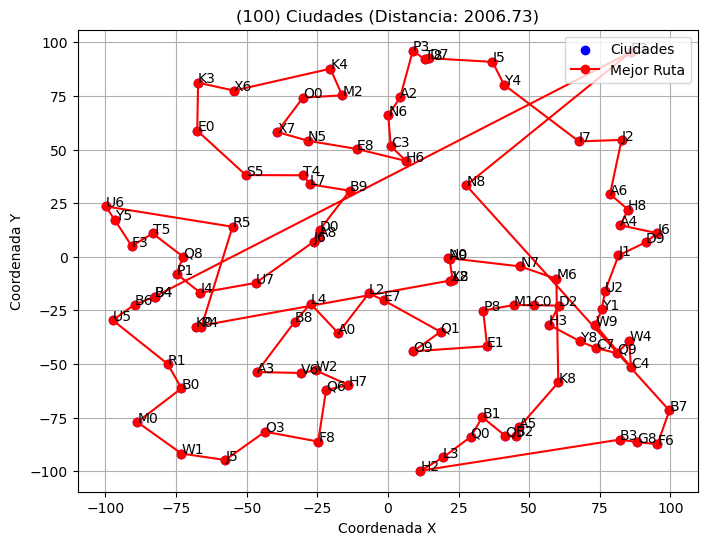


Probando con 10 ciudades...
Tiempo de ejecución: 00:00
Distancia mínima entre nodos: 13.857849761056004
Distancia máxima entre nodos: 196.87965867503937
Distancia promedio entre nodos: 109.71153649851156
Distancia Total mínima posible: 154.46173282445946
Distancia Total máxima posible: 370.7081587787027
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 570.6995632723516
Tiempo de ejecución: 0.24 segundos


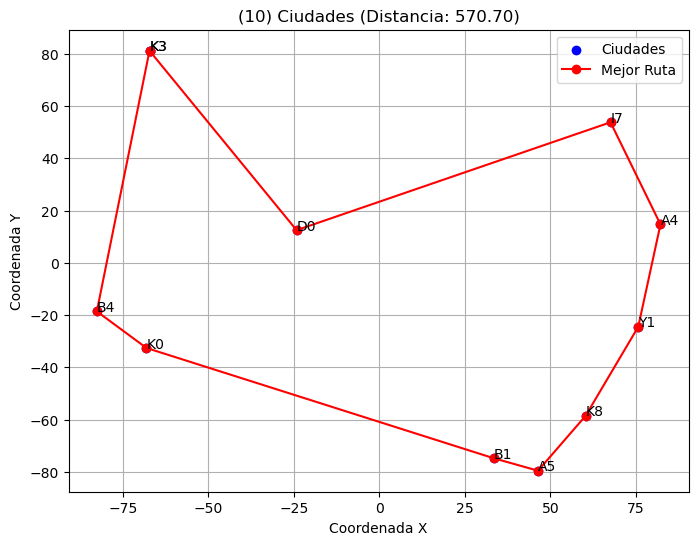


Probando con 20 ciudades...
Tiempo de ejecución: 00:05
Distancia mínima entre nodos: 2.0999999999999943
Distancia máxima entre nodos: 199.3987211593896
Distancia promedio entre nodos: 104.14313439828004
Distancia Total mínima posible: 265.6078359957001
Distancia Total máxima posible: 637.4588063896803
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 718.4738041093337
Tiempo de ejecución: 5.22 segundos


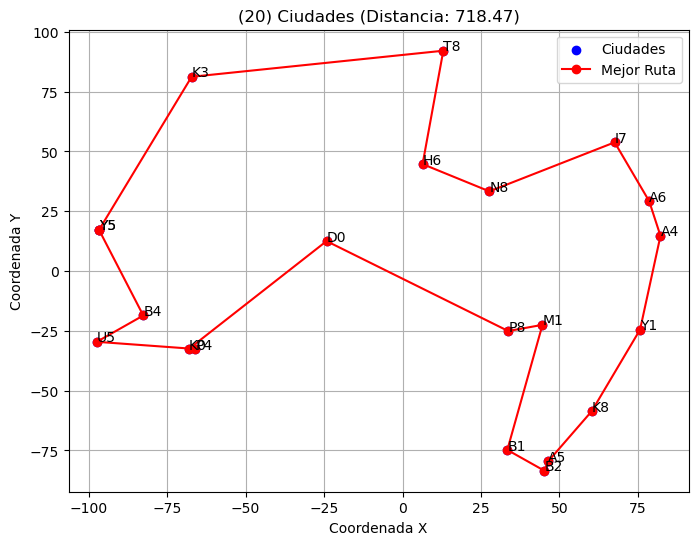


Probando con 30 ciudades...
Tiempo de ejecución: 00:30
Distancia mínima entre nodos: 2.0999999999999943
Distancia máxima entre nodos: 199.3987211593896
Distancia promedio entre nodos: 103.75681401513364
Distancia Total mínima posible: 396.9630525567511
Distancia Total máxima posible: 952.7113261362026
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 981.1916435303079
Tiempo de ejecución: 30.20 segundos


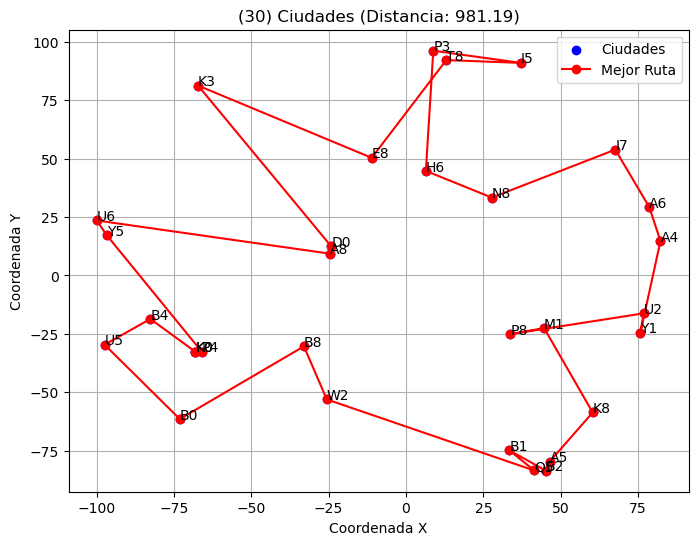


Probando con 40 ciudades...
Tiempo de ejecución: 00:30
Distancia mínima entre nodos: 2.0999999999999943
Distancia máxima entre nodos: 202.6153992173349
Distancia promedio entre nodos: 101.09527133150198
Distancia Total mínima posible: 515.9763566575099
Distancia Total máxima posible: 1238.3432559780238
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 1131.7867881280401
Tiempo de ejecución: 30.35 segundos


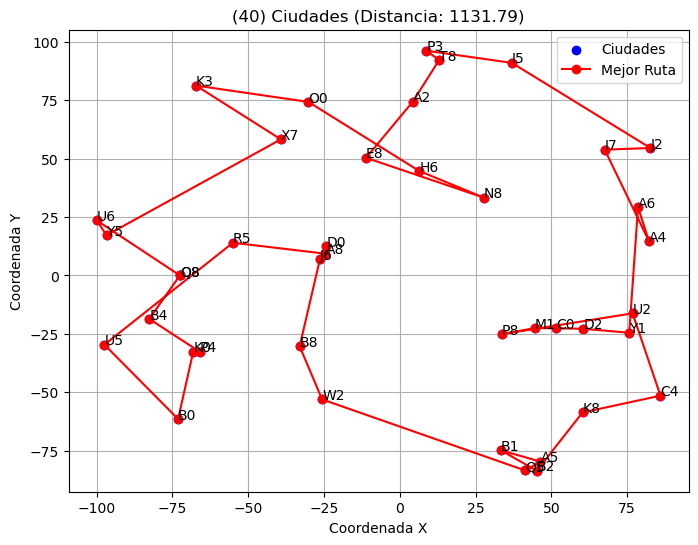


Probando con 50 ciudades...
Tiempo de ejecución: 00:30
Distancia mínima entre nodos: 2.0999999999999943
Distancia máxima entre nodos: 202.6153992173349
Distancia promedio entre nodos: 97.67061537707829
Distancia Total mínima posible: 623.5663461067393
Distancia Total máxima posible: 1496.5592306561741
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 1125.9456376118662
Tiempo de ejecución: 30.49 segundos


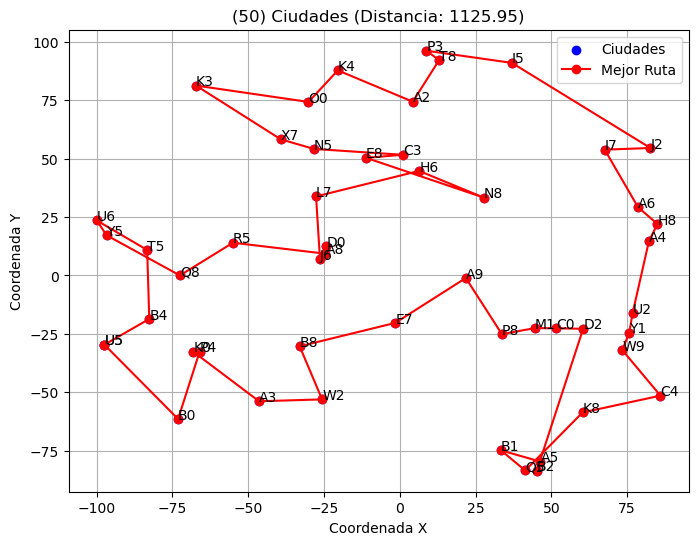

In [2]:
from util import *
from util_nearest_neighbor import nearest_neighbor
# https://baobabsoluciones.es/blog/2020/10/01/problema-del-viajante/

class TSP:
    def __init__(self, ciudades, distancias, heuristics: List[str]):
        self.max_possible_distance = None
        self.min_possible_distance = None
        self.ciudades = ciudades
        self.distancias = distancias
        self.heuristics = heuristics
        self.min_distance = get_min_distance(distancias)
        self.max_distance = get_max_distance(distancias)
        self.average_distance = get_average_distance(distancias)
        self.average_distance_for_city = get_average_distance_for_city(distancias)
        self.min_distance_for_city = get_min_distances(distancias)
        self.max_distance_for_city = get_max_distances(distancias)
        self.cal_min_max_distances()

    def cal_min_max_distances(self):
        medium_low_distance = (self.min_distance + self.average_distance) / 2
        self.min_possible_distance = medium_low_distance * len(self.ciudades) * 0.25
        self.max_possible_distance = medium_low_distance * len(self.ciudades) * 0.6


    def print_min_max_distances(self):
        print(f"Distancia mínima entre nodos: {self.min_distance}")
        print(f"Distancia máxima entre nodos: {self.max_distance}")
        print(f"Distancia promedio entre nodos: {self.average_distance}")
        print(f"Distancia Total mínima posible: {self.min_possible_distance}")
        print(f"Distancia Total máxima posible: {self.max_possible_distance}")
        print(f"Heurísticas aplicadas: {self.heuristics}")

    def encontrar_la_ruta_mas_corta(self, mipgap, time_limit, tee):
        start_time = dt.datetime.now()

        _model = pyo.ConcreteModel()

        cities = list(self.ciudades.keys())
        n_cities = len(cities)


        # Sets to work with (conjuntos)
        _model.M = pyo.Set(initialize=self.ciudades.keys())
        _model.N = pyo.Set(initialize=self.ciudades.keys())

        # Index for the dummy variable u
        _model.U = pyo.Set(initialize=cities[1:])

        # Variables
        _model.x = pyo.Var(_model.N, _model.M, within=pyo.Binary)
        _model.u = pyo.Var(_model.N, bounds=(0, n_cities - 1), within=pyo.NonNegativeIntegers)

        # Objetive Function: (función objetivo a minimizar)
        def obj_rule(model):
            return sum(self.distancias[i, j] * model.x[i, j] for i in model.N for j in model.M if i != j)

        _model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

        # Restricciones
        # Desde cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_desde(model, city_j):
            return sum(model.x[i, city_j]  for i in model.N if city_j != i) == 1

        _model.one_way_i_j = pyo.Constraint(_model.M, rule=regla_una_entrada_una_salida_por_ciudad_desde)

        # Hacia cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_hacia(model, city_i):
            return sum(model.x[city_i, j] for j in model.M if city_i != j) == 1

        _model.one_way_j_i = pyo.Constraint(_model.N, rule=regla_una_entrada_una_salida_por_ciudad_hacia)

        def rule_formando_path(model, i, j):
            if i != j:
                return model.u[i] - model.u[j] + model.x[i, j] * n_cities <= n_cities - 1
            else:
                # No se puede ir de una ciudad a la misma
                return pyo.Constraint.Skip

        _model.complete_path = pyo.Constraint(_model.U, _model.N, rule=rule_formando_path)

        def rule_asegurar_viaje(model, i, j):
            if i == j:
                return model.x[i, j] == 0
            return pyo.Constraint.Skip
        _model.no_self_travel = pyo.Constraint(_model.N, _model.M, rule=rule_asegurar_viaje)

        # Heurísticas:

        # Añadiendo limites a la función objetivo como una heurística
        if "limitar_funcion_objetivo" in self.heuristics:
            _model.obj_lower_bound = pyo.Constraint(expr=_model.obj >= self.min_possible_distance)
            _model.obj_upper_bound = pyo.Constraint(expr=_model.obj <= self.max_possible_distance)

        if "vecino_cercano" in self.heuristics:
            def rule_vecino_cercano(model, i, j):
                if i == j:
                    return pyo.Constraint.Skip
                print(i, self.min_distance, self.average_distance,  self.min_distance_for_city[i], self.max_distance_for_city[i], self.average_distance_for_city[i])
                if self.average_distance_for_city[i] > self.average_distance:
                     return pyo.Constraint.Skip
                expr = model.x[i,j] * self.distancias[i,j] <= (self.average_distance_for_city[i] + self.min_distance_for_city[i])/2
                return expr
            _model.nearest_neighbor = pyo.Constraint(_model.N, _model.M, rule=rule_vecino_cercano)

        # Initialize empty set for dynamic constraints (optional)
        # _model.subtour_constraint = pyo.ConstraintList()


        # Resolver el modelo
        solver = pyo.SolverFactory('glpk')
        solver.options['mipgap'] = mipgap
        solver.options['tmlim'] = time_limit
        results = solver.solve(_model, tee=tee)

        execution_time = dt.datetime.now() - start_time
        print(f"Tiempo de ejecución: {delta_time_mm_ss(execution_time)}")
        self.print_min_max_distances()

        # Mostrar resultados
        if results.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Ruta óptima encontrada:")
        else:
            print("No se encontró una solución óptima, la siguiente es la mejor solución encontrada:")

        edges = dict()
        valid_paths = []
        for v in _model.component_data_objects(pyo.Var):
            if v.domain == pyo.Boolean and v.value is not None and v.value > 0:
                edge = re.search(r'\[(\w\d)*,(\w\d)*]', v.name)
                city1, city2 = edge.group(1), edge.group(2)
                key = f"{city1}_{city2}"
                # Esto evita caer en ciclos cerrados
                if key not in valid_paths:
                    valid_paths += [f"{city1}_{city2}", f"{city2}_{city1}"]
                    edges[city1] = city2

        initial_city = cities[0]
        path = get_path(edges, initial_city, [])
        path.append(path[0])
        distance = calculate_path_distance(self.distancias, path)
        print("Distancia total recorrida:", distance)
        return path



    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, self.distancias, ruta, mostrar_anotaciones)

def study_nearest_neighbor(n_cities):
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    ruta = nearest_neighbor(ciudades, distancias)
    plotear_ruta(ciudades, distancias, ruta, True)

def study_case_1():
    # Probar con diferentes cantidades de ciudades
    for n_cities in [10, 20, 30, 40, 50]:
        print(f"\nProbando con {n_cities} ciudades...")
        ciudades, distancias = generar_ciudades_con_distancias(n_cities)
        heuristics = []
        mipgap = 0.05
        time_limit = 30
        tee = False

        tsp = TSP(ciudades, distancias, heuristics)

        start_time = time.time()
        ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
        end_time = time.time()

        elapsed_time = end_time - start_time
        print(f"Tiempo de ejecución: {elapsed_time:.2f} segundos")

        tsp.plotear_resultado(ruta)

def study_case_2():
    n_cities = 70
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['limitar_funcion_objetivo']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.2
    time_limit = 40
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)

def study_case_3():
    n_cities = 100
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['vecino_cercano']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.05
    time_limit = 60
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)


if __name__ == "__main__":
    print("Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.")
    # as reference, see nearest neighbor heuristic
    study_nearest_neighbor(100)
    # Solve the TSP problem
    study_case_1()
    # study_case_2()
    #study_case_3()

Como se puede observar en las corridas anteriores. El número de ciudades es el factor diferencial al momento de tomar tiempos ya que aumenta el procesamiento de la información. Como el tiempo limiti sigue establecido a 30 segundos, todos los ejemplos tienen el mismo limite de tiempo. 

Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.


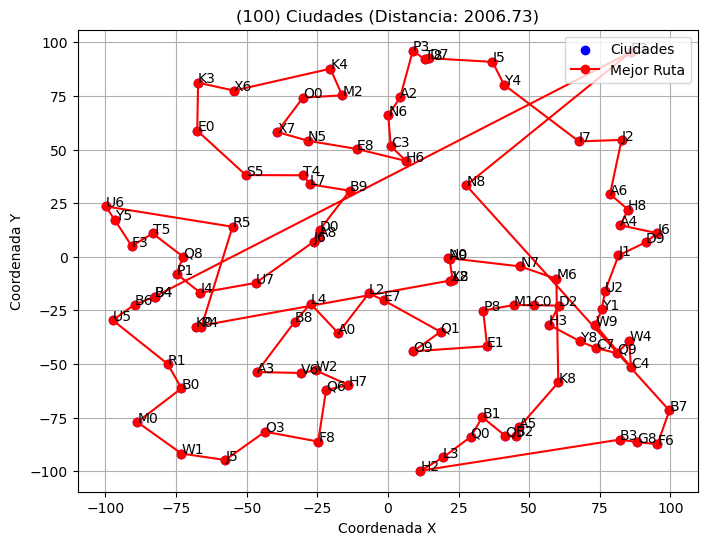


Probando con 10 ciudades...
B4 13.857849761056004 109.71153649851156 20.155644370746373 168.13069321215565 122.28512452312553
B4 13.857849761056004 109.71153649851156 20.155644370746373 168.13069321215565 122.28512452312553
B4 13.857849761056004 109.71153649851156 20.155644370746373 168.13069321215565 122.28512452312553
B4 13.857849761056004 109.71153649851156 20.155644370746373 168.13069321215565 122.28512452312553
B4 13.857849761056004 109.71153649851156 20.155644370746373 168.13069321215565 122.28512452312553
B4 13.857849761056004 109.71153649851156 20.155644370746373 168.13069321215565 122.28512452312553
B4 13.857849761056004 109.71153649851156 20.155644370746373 168.13069321215565 122.28512452312553
B4 13.857849761056004 109.71153649851156 20.155644370746373 168.13069321215565 122.28512452312553
B4 13.857849761056004 109.71153649851156 20.155644370746373 168.13069321215565 122.28512452312553
D0 13.857849761056004 109.71153649851156 62.938223680049944 116.04641312854093 94.9818567

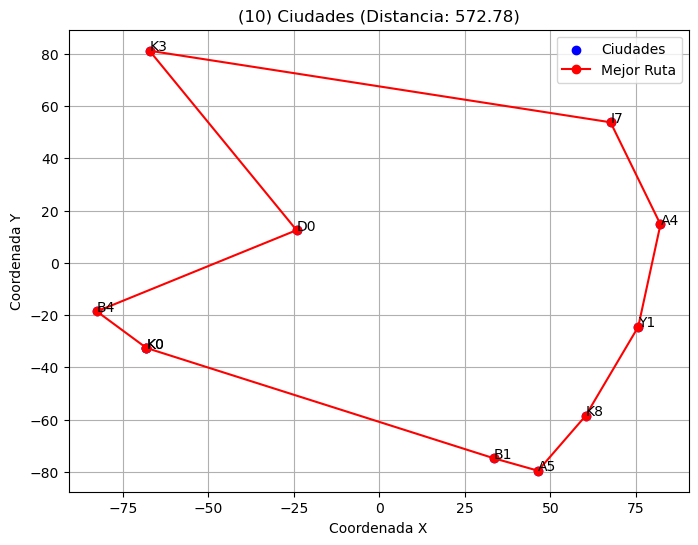


Probando con 20 ciudades...
B4 2.0999999999999943 104.14313439828004 18.440173534975216 168.137681677844 111.14703487469164
B4 2.0999999999999943 104.14313439828004 18.440173534975216 168.137681677844 111.14703487469164
B4 2.0999999999999943 104.14313439828004 18.440173534975216 168.137681677844 111.14703487469164
B4 2.0999999999999943 104.14313439828004 18.440173534975216 168.137681677844 111.14703487469164
B4 2.0999999999999943 104.14313439828004 18.440173534975216 168.137681677844 111.14703487469164
B4 2.0999999999999943 104.14313439828004 18.440173534975216 168.137681677844 111.14703487469164
B4 2.0999999999999943 104.14313439828004 18.440173534975216 168.137681677844 111.14703487469164
B4 2.0999999999999943 104.14313439828004 18.440173534975216 168.137681677844 111.14703487469164
B4 2.0999999999999943 104.14313439828004 18.440173534975216 168.137681677844 111.14703487469164
B4 2.0999999999999943 104.14313439828004 18.440173534975216 168.137681677844 111.14703487469164
B4 2.099999

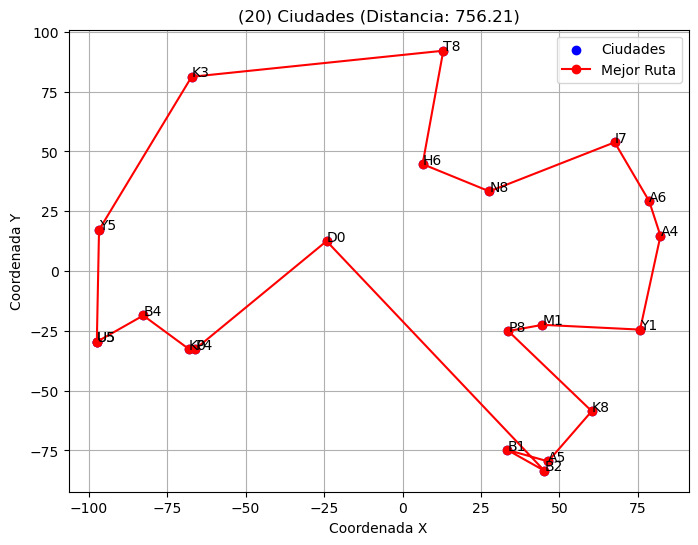


Probando con 30 ciudades...
B4 2.0999999999999943 103.75681401513364 18.440173534975216 168.137681677844 106.571807915307
B4 2.0999999999999943 103.75681401513364 18.440173534975216 168.137681677844 106.571807915307
B4 2.0999999999999943 103.75681401513364 18.440173534975216 168.137681677844 106.571807915307
B4 2.0999999999999943 103.75681401513364 18.440173534975216 168.137681677844 106.571807915307
B4 2.0999999999999943 103.75681401513364 18.440173534975216 168.137681677844 106.571807915307
B4 2.0999999999999943 103.75681401513364 18.440173534975216 168.137681677844 106.571807915307
B4 2.0999999999999943 103.75681401513364 18.440173534975216 168.137681677844 106.571807915307
B4 2.0999999999999943 103.75681401513364 18.440173534975216 168.137681677844 106.571807915307
B4 2.0999999999999943 103.75681401513364 18.440173534975216 168.137681677844 106.571807915307
B4 2.0999999999999943 103.75681401513364 18.440173534975216 168.137681677844 106.571807915307
B4 2.0999999999999943 103.75681

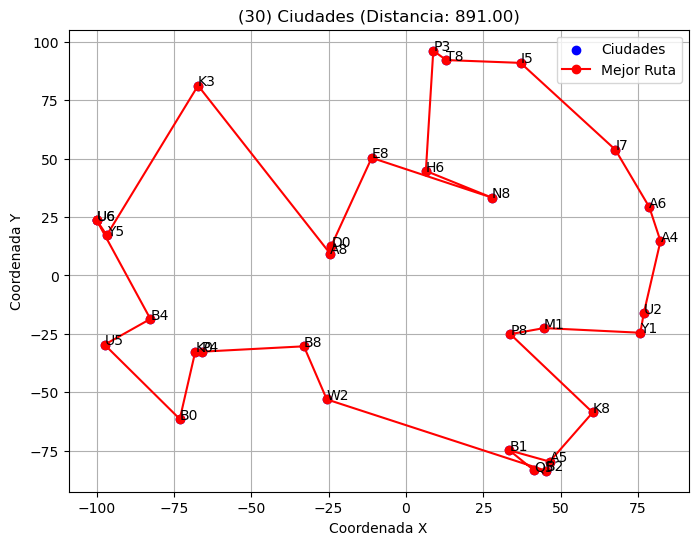


Probando con 40 ciudades...
B4 2.0999999999999943 101.09527133150198 18.440173534975216 180.7420814309717 106.87891356412773
B4 2.0999999999999943 101.09527133150198 18.440173534975216 180.7420814309717 106.87891356412773
B4 2.0999999999999943 101.09527133150198 18.440173534975216 180.7420814309717 106.87891356412773
B4 2.0999999999999943 101.09527133150198 18.440173534975216 180.7420814309717 106.87891356412773
B4 2.0999999999999943 101.09527133150198 18.440173534975216 180.7420814309717 106.87891356412773
B4 2.0999999999999943 101.09527133150198 18.440173534975216 180.7420814309717 106.87891356412773
B4 2.0999999999999943 101.09527133150198 18.440173534975216 180.7420814309717 106.87891356412773
B4 2.0999999999999943 101.09527133150198 18.440173534975216 180.7420814309717 106.87891356412773
B4 2.0999999999999943 101.09527133150198 18.440173534975216 180.7420814309717 106.87891356412773
B4 2.0999999999999943 101.09527133150198 18.440173534975216 180.7420814309717 106.87891356412773
B

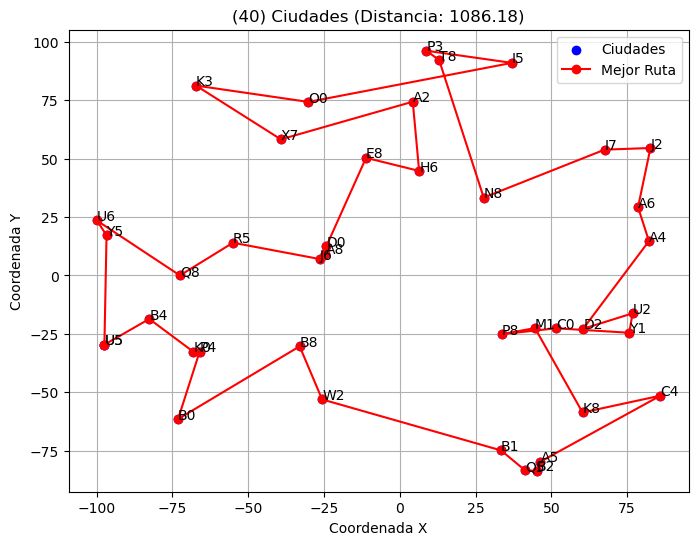


Probando con 50 ciudades...
B4 2.0999999999999943 97.67061537707829 18.440173534975216 180.7420814309717 105.37341518064503
B4 2.0999999999999943 97.67061537707829 18.440173534975216 180.7420814309717 105.37341518064503
B4 2.0999999999999943 97.67061537707829 18.440173534975216 180.7420814309717 105.37341518064503
B4 2.0999999999999943 97.67061537707829 18.440173534975216 180.7420814309717 105.37341518064503
B4 2.0999999999999943 97.67061537707829 18.440173534975216 180.7420814309717 105.37341518064503
B4 2.0999999999999943 97.67061537707829 18.440173534975216 180.7420814309717 105.37341518064503
B4 2.0999999999999943 97.67061537707829 18.440173534975216 180.7420814309717 105.37341518064503
B4 2.0999999999999943 97.67061537707829 18.440173534975216 180.7420814309717 105.37341518064503
B4 2.0999999999999943 97.67061537707829 18.440173534975216 180.7420814309717 105.37341518064503
B4 2.0999999999999943 97.67061537707829 18.440173534975216 180.7420814309717 105.37341518064503
B4 2.099999

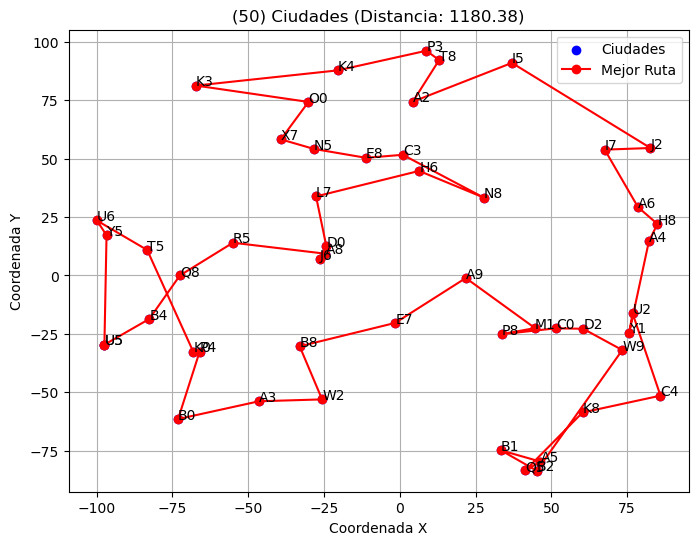

In [3]:
from util import *
from util_nearest_neighbor import nearest_neighbor
# https://baobabsoluciones.es/blog/2020/10/01/problema-del-viajante/

class TSP:
    def __init__(self, ciudades, distancias, heuristics: List[str]):
        self.max_possible_distance = None
        self.min_possible_distance = None
        self.ciudades = ciudades
        self.distancias = distancias
        self.heuristics = heuristics
        self.min_distance = get_min_distance(distancias)
        self.max_distance = get_max_distance(distancias)
        self.average_distance = get_average_distance(distancias)
        self.average_distance_for_city = get_average_distance_for_city(distancias)
        self.min_distance_for_city = get_min_distances(distancias)
        self.max_distance_for_city = get_max_distances(distancias)
        self.cal_min_max_distances()

    def cal_min_max_distances(self):
        medium_low_distance = (self.min_distance + self.average_distance) / 2
        self.min_possible_distance = medium_low_distance * len(self.ciudades) * 0.25
        self.max_possible_distance = medium_low_distance * len(self.ciudades) * 0.6


    def print_min_max_distances(self):
        print(f"Distancia mínima entre nodos: {self.min_distance}")
        print(f"Distancia máxima entre nodos: {self.max_distance}")
        print(f"Distancia promedio entre nodos: {self.average_distance}")
        print(f"Distancia Total mínima posible: {self.min_possible_distance}")
        print(f"Distancia Total máxima posible: {self.max_possible_distance}")
        print(f"Heurísticas aplicadas: {self.heuristics}")

    def encontrar_la_ruta_mas_corta(self, mipgap, time_limit, tee):
        start_time = dt.datetime.now()

        _model = pyo.ConcreteModel()

        cities = list(self.ciudades.keys())
        n_cities = len(cities)


        # Sets to work with (conjuntos)
        _model.M = pyo.Set(initialize=self.ciudades.keys())
        _model.N = pyo.Set(initialize=self.ciudades.keys())

        # Index for the dummy variable u
        _model.U = pyo.Set(initialize=cities[1:])

        # Variables
        _model.x = pyo.Var(_model.N, _model.M, within=pyo.Binary)
        _model.u = pyo.Var(_model.N, bounds=(0, n_cities - 1), within=pyo.NonNegativeIntegers)

        # Objetive Function: (función objetivo a minimizar)
        def obj_rule(model):
            return sum(self.distancias[i, j] * model.x[i, j] for i in model.N for j in model.M if i != j)

        _model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

        # Restricciones
        # Desde cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_desde(model, city_j):
            return sum(model.x[i, city_j]  for i in model.N if city_j != i) == 1

        _model.one_way_i_j = pyo.Constraint(_model.M, rule=regla_una_entrada_una_salida_por_ciudad_desde)

        # Hacia cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_hacia(model, city_i):
            return sum(model.x[city_i, j] for j in model.M if city_i != j) == 1

        _model.one_way_j_i = pyo.Constraint(_model.N, rule=regla_una_entrada_una_salida_por_ciudad_hacia)

        def rule_formando_path(model, i, j):
            if i != j:
                return model.u[i] - model.u[j] + model.x[i, j] * n_cities <= n_cities - 1
            else:
                # No se puede ir de una ciudad a la misma
                return pyo.Constraint.Skip

        _model.complete_path = pyo.Constraint(_model.U, _model.N, rule=rule_formando_path)

        def rule_asegurar_viaje(model, i, j):
            if i == j:
                return model.x[i, j] == 0
            return pyo.Constraint.Skip
        _model.no_self_travel = pyo.Constraint(_model.N, _model.M, rule=rule_asegurar_viaje)

        # Heurísticas:

        # Añadiendo limites a la función objetivo como una heurística
        if "limitar_funcion_objetivo" in self.heuristics:
            _model.obj_lower_bound = pyo.Constraint(expr=_model.obj >= self.min_possible_distance)
            _model.obj_upper_bound = pyo.Constraint(expr=_model.obj <= self.max_possible_distance)

        if "vecino_cercano" in self.heuristics:
            def rule_vecino_cercano(model, i, j):
                if i == j:
                    return pyo.Constraint.Skip
                print(i, self.min_distance, self.average_distance,  self.min_distance_for_city[i], self.max_distance_for_city[i], self.average_distance_for_city[i])
                if self.average_distance_for_city[i] > self.average_distance:
                     return pyo.Constraint.Skip
                expr = model.x[i,j] * self.distancias[i,j] <= (self.average_distance_for_city[i] + self.min_distance_for_city[i])/2
                return expr
            _model.nearest_neighbor = pyo.Constraint(_model.N, _model.M, rule=rule_vecino_cercano)

        # Initialize empty set for dynamic constraints (optional)
        # _model.subtour_constraint = pyo.ConstraintList()


        # Resolver el modelo
        solver = pyo.SolverFactory('glpk')
        solver.options['mipgap'] = mipgap
        solver.options['tmlim'] = time_limit
        results = solver.solve(_model, tee=tee)

        execution_time = dt.datetime.now() - start_time
        print(f"Tiempo de ejecución: {delta_time_mm_ss(execution_time)}")
        self.print_min_max_distances()

        # Mostrar resultados
        if results.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Ruta óptima encontrada:")
        else:
            print("No se encontró una solución óptima, la siguiente es la mejor solución encontrada:")

        edges = dict()
        valid_paths = []
        for v in _model.component_data_objects(pyo.Var):
            if v.domain == pyo.Boolean and v.value is not None and v.value > 0:
                edge = re.search(r'\[(\w\d)*,(\w\d)*]', v.name)
                city1, city2 = edge.group(1), edge.group(2)
                key = f"{city1}_{city2}"
                # Esto evita caer en ciclos cerrados
                if key not in valid_paths:
                    valid_paths += [f"{city1}_{city2}", f"{city2}_{city1}"]
                    edges[city1] = city2

        initial_city = cities[0]
        path = get_path(edges, initial_city, [])
        path.append(path[0])
        distance = calculate_path_distance(self.distancias, path)
        print("Distancia total recorrida:", distance)
        return path



    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, self.distancias, ruta, mostrar_anotaciones)

def study_nearest_neighbor(n_cities):
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    ruta = nearest_neighbor(ciudades, distancias)
    plotear_ruta(ciudades, distancias, ruta, True)

def study_case_1():
    # Probar con diferentes cantidades de ciudades
    for n_cities in [10, 20, 30, 40, 50]:
        print(f"\nProbando con {n_cities} ciudades...")
        ciudades, distancias = generar_ciudades_con_distancias(n_cities)
        heuristics = ['vecino_cercano']
        mipgap = 0.05
        time_limit = 30
        tee = False

        tsp = TSP(ciudades, distancias, heuristics)

        start_time = time.time()
        ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
        end_time = time.time()

        elapsed_time = end_time - start_time
        print(f"Tiempo de ejecución: {elapsed_time:.2f} segundos")

        tsp.plotear_resultado(ruta)

def study_case_2():
    n_cities = 70
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['limitar_funcion_objetivo']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.2
    time_limit = 40
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)

def study_case_3():
    n_cities = 100
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['vecino_cercano']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.05
    time_limit = 60
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)


if __name__ == "__main__":
    print("Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.")
    # as reference, see nearest neighbor heuristic
    study_nearest_neighbor(100)
    # Solve the TSP problem
    study_case_1()
    # study_case_2()
    #study_case_3()

Usando la heurística de 'vecino cercano' se puede observar una mejora en los tiempos de ejecución. Se sigue sin encontrar la mejor ruta en con las heuristicas aplicadas. Sin embargo, en algunos casos la distancia total recorrida con el resultado de la heuristica aplicada es mas grande que en la corrida inicial. Por otra parte, los tiempos de ejecucion con las primeras ciudades mejora bastante con la heurisitca aplicada. 

## Analizar parámetro tee	

Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.


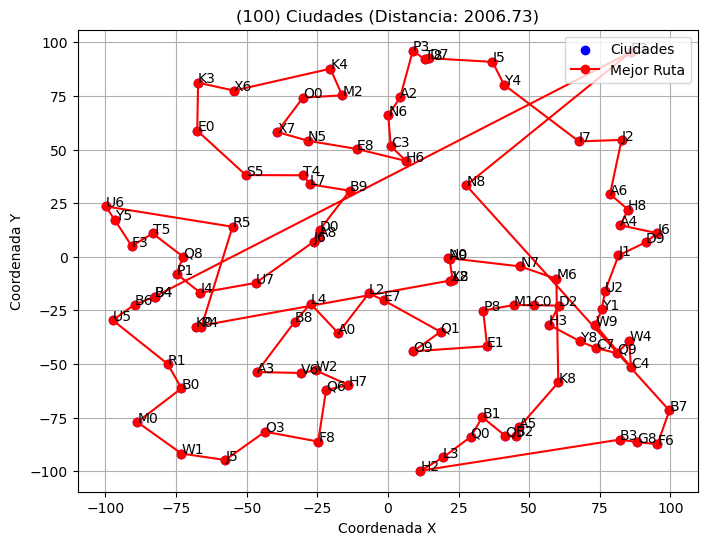

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.2 --tmlim 40 --write C:\Users\ccarr\AppData\Local\Temp\tmpaafdk_ut.glpk.raw
 --wglp C:\Users\ccarr\AppData\Local\Temp\tmp2x21hxyl.glpk.glp --cpxlp C:\Users\ccarr\AppData\Local\Temp\tmpwyl_wx5z.pyomo.lp
Reading problem data from 'C:\Users\ccarr\AppData\Local\Temp\tmpwyl_wx5z.pyomo.lp'...
C:\Users\ccarr\AppData\Local\Temp\tmpwyl_wx5z.pyomo.lp:58473: warning: lower bound of variable 'x9804' redefined
C:\Users\ccarr\AppData\Local\Temp\tmpwyl_wx5z.pyomo.lp:58473: warning: upper bound of variable 'x9804' redefined
4973 rows, 4970 columns, 33673 non-zeros
4970 integer variables, 4900 of which are binary
63373 lines were read
Writing problem data to 'C:\Users\ccarr\AppData\Local\Temp\tmp2x21hxyl.glpk.glp'...
53422 lines were written
GLPK Integer Optimizer, v4.65
4973 rows, 4970 columns, 33673 non-zeros
4970 integer variables, 4900 of which are binary
Preprocessing...
4903 rows, 4900 columns, 33603 non-zer

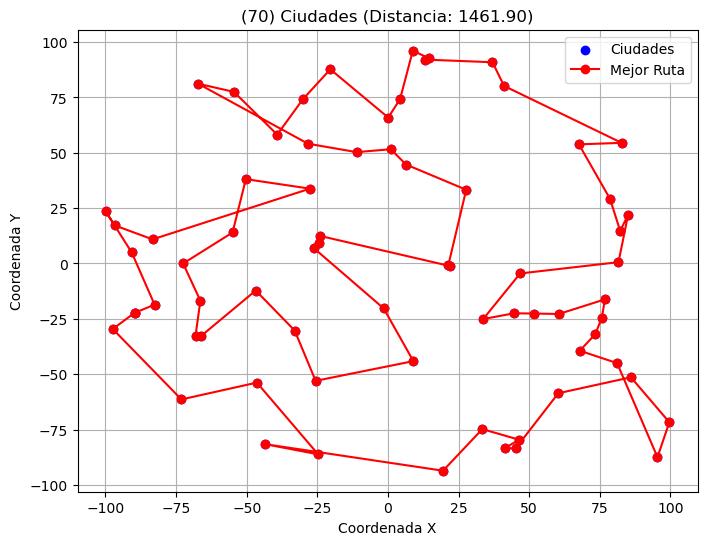

In [4]:
class TSP:
    def __init__(self, ciudades, distancias, heuristics: List[str]):
        self.max_possible_distance = None
        self.min_possible_distance = None
        self.ciudades = ciudades
        self.distancias = distancias
        self.heuristics = heuristics
        self.min_distance = get_min_distance(distancias)
        self.max_distance = get_max_distance(distancias)
        self.average_distance = get_average_distance(distancias)
        self.average_distance_for_city = get_average_distance_for_city(distancias)
        self.min_distance_for_city = get_min_distances(distancias)
        self.max_distance_for_city = get_max_distances(distancias)
        self.cal_min_max_distances()

    def cal_min_max_distances(self):
        medium_low_distance = (self.min_distance + self.average_distance) / 2
        self.min_possible_distance = medium_low_distance * len(self.ciudades) * 0.25
        self.max_possible_distance = medium_low_distance * len(self.ciudades) * 0.6


    def print_min_max_distances(self):
        print(f"Distancia mínima entre nodos: {self.min_distance}")
        print(f"Distancia máxima entre nodos: {self.max_distance}")
        print(f"Distancia promedio entre nodos: {self.average_distance}")
        print(f"Distancia Total mínima posible: {self.min_possible_distance}")
        print(f"Distancia Total máxima posible: {self.max_possible_distance}")
        print(f"Heurísticas aplicadas: {self.heuristics}")

    def encontrar_la_ruta_mas_corta(self, mipgap, time_limit, tee):
        start_time = dt.datetime.now()

        _model = pyo.ConcreteModel()

        cities = list(self.ciudades.keys())
        n_cities = len(cities)


        # Sets to work with (conjuntos)
        _model.M = pyo.Set(initialize=self.ciudades.keys())
        _model.N = pyo.Set(initialize=self.ciudades.keys())

        # Index for the dummy variable u
        _model.U = pyo.Set(initialize=cities[1:])

        # Variables
        _model.x = pyo.Var(_model.N, _model.M, within=pyo.Binary)
        _model.u = pyo.Var(_model.N, bounds=(0, n_cities - 1), within=pyo.NonNegativeIntegers)

        # Objetive Function: (función objetivo a minimizar)
        def obj_rule(model):
            return sum(self.distancias[i, j] * model.x[i, j] for i in model.N for j in model.M if i != j)

        _model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

        # Restricciones
        # Desde cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_desde(model, city_j):
            return sum(model.x[i, city_j]  for i in model.N if city_j != i) == 1

        _model.one_way_i_j = pyo.Constraint(_model.M, rule=regla_una_entrada_una_salida_por_ciudad_desde)

        # Hacia cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_hacia(model, city_i):
            return sum(model.x[city_i, j] for j in model.M if city_i != j) == 1

        _model.one_way_j_i = pyo.Constraint(_model.N, rule=regla_una_entrada_una_salida_por_ciudad_hacia)

        def rule_formando_path(model, i, j):
            if i != j:
                return model.u[i] - model.u[j] + model.x[i, j] * n_cities <= n_cities - 1
            else:
                # No se puede ir de una ciudad a la misma
                return pyo.Constraint.Skip

        _model.complete_path = pyo.Constraint(_model.U, _model.N, rule=rule_formando_path)

        def rule_asegurar_viaje(model, i, j):
            if i == j:
                return model.x[i, j] == 0
            return pyo.Constraint.Skip
        _model.no_self_travel = pyo.Constraint(_model.N, _model.M, rule=rule_asegurar_viaje)

        # Heurísticas:

        # Añadiendo limites a la función objetivo como una heurística
        if "limitar_funcion_objetivo" in self.heuristics:
            _model.obj_lower_bound = pyo.Constraint(expr=_model.obj >= self.min_possible_distance)
            _model.obj_upper_bound = pyo.Constraint(expr=_model.obj <= self.max_possible_distance)

        if "vecino_cercano" in self.heuristics:
            def rule_vecino_cercano(model, i, j):
                if i == j:
                    return pyo.Constraint.Skip
                print(i, self.min_distance, self.average_distance,  self.min_distance_for_city[i], self.max_distance_for_city[i], self.average_distance_for_city[i])
                if self.average_distance_for_city[i] > self.average_distance:
                     return pyo.Constraint.Skip
                expr = model.x[i,j] * self.distancias[i,j] <= (self.average_distance_for_city[i] + self.min_distance_for_city[i])/2
                return expr
            _model.nearest_neighbor = pyo.Constraint(_model.N, _model.M, rule=rule_vecino_cercano)

        # Initialize empty set for dynamic constraints (optional)
        # _model.subtour_constraint = pyo.ConstraintList()


        # Resolver el modelo
        solver = pyo.SolverFactory('glpk')
        solver.options['mipgap'] = mipgap
        solver.options['tmlim'] = time_limit
        results = solver.solve(_model, tee=tee)

        execution_time = dt.datetime.now() - start_time
        print(f"Tiempo de ejecución: {delta_time_mm_ss(execution_time)}")
        self.print_min_max_distances()

        # Mostrar resultados
        if results.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Ruta óptima encontrada:")
        else:
            print("No se encontró una solución óptima, la siguiente es la mejor solución encontrada:")

        edges = dict()
        valid_paths = []
        for v in _model.component_data_objects(pyo.Var):
            if v.domain == pyo.Boolean and v.value is not None and v.value > 0:
                edge = re.search(r'\[(\w\d)*,(\w\d)*]', v.name)
                city1, city2 = edge.group(1), edge.group(2)
                key = f"{city1}_{city2}"
                # Esto evita caer en ciclos cerrados
                if key not in valid_paths:
                    valid_paths += [f"{city1}_{city2}", f"{city2}_{city1}"]
                    edges[city1] = city2

        initial_city = cities[0]
        path = get_path(edges, initial_city, [])
        path.append(path[0])
        distance = calculate_path_distance(self.distancias, path)
        print("Distancia total recorrida:", distance)
        return path



    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, self.distancias, ruta, mostrar_anotaciones)

def study_nearest_neighbor(n_cities):
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    ruta = nearest_neighbor(ciudades, distancias)
    plotear_ruta(ciudades, distancias, ruta, True)

def study_case_1():
    # Probar con diferentes cantidades de ciudades
    for n_cities in [10, 20, 30, 40, 50]:
        print(f"\nProbando con {n_cities} ciudades...")
        ciudades, distancias = generar_ciudades_con_distancias(n_cities)
        heuristics = ['vecino_cercano']
        mipgap = 0.05
        time_limit = 30
        tee = False

        tsp = TSP(ciudades, distancias, heuristics)

        start_time = time.time()
        ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
        end_time = time.time()

        elapsed_time = end_time - start_time
        print(f"Tiempo de ejecución: {elapsed_time:.2f} segundos")

        tsp.plotear_resultado(ruta)

def study_case_2():
    n_cities = 70
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['limitar_funcion_objetivo']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.2
    time_limit = 40
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)

def study_case_3():
    n_cities = 100
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['vecino_cercano']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.05
    time_limit = 60
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)


if __name__ == "__main__":
    print("Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.")
    # as reference, see nearest neighbor heuristic
    study_nearest_neighbor(100)
    # Solve the TSP problem
    #study_case_1()
    study_case_2()
    #study_case_3()

El parametro tee ayuda a monitorear el progreso de optimización. También se puede ver el tiempo límite  antes de encontrar una solución óptima. 

Interpretacion:

Se leyeron 4973 restricciones y 4970 variables

Algunas advertencias por redefinición de límites de variables.


Se encontró una solución óptima al LP relajado (964.009).

El tiempo límite fue alcanzado antes de encontrar una solución óptima.

Gap al final:

El mejor lower bound fue  995.39

La mejor solución entera (mip) fue  1461.90

El gap era de  31.9% al finalizar, por eso no es una solución óptima.

Distancia total recorrida (solución actual): 1461.90

Distancia mínima posible (teórica o relajada): 887.24

Distancia máxima posible: 2129.37

Heurística usada:
'limitar_funcion_objetivo': probablemente un recorte para guiar la búsqueda del solver más rápidamente hacia soluciones prometedoras.

Conclusión final:
El parámetro tee te permitió ver estos logs completos del solver. 

El resultado final:
No se encontró una solución óptima, pero sí una factible bastante buena.
La búsqueda fue interrumpida por tiempo límite.

## Aplicar	heurística	de	limites a la funcion objetivo (caso 2 con 70 ciudades)	

Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.


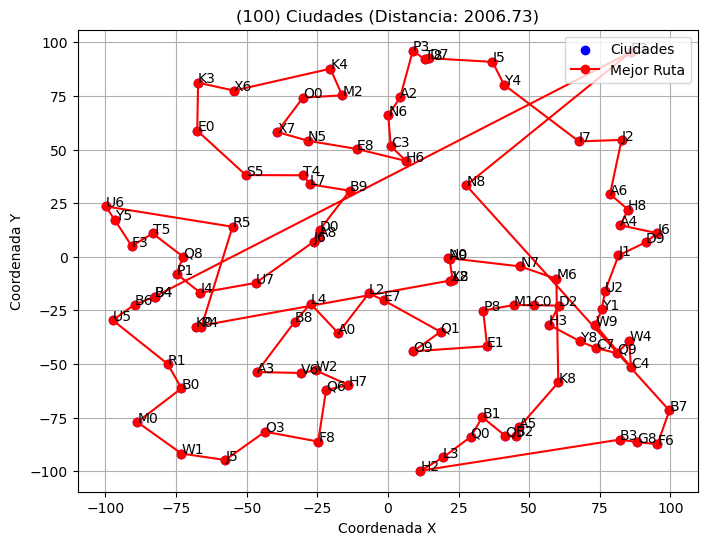

Tiempo de ejecución: 00:40
Distancia mínima entre nodos: 0.6403124237432862
Distancia máxima entre nodos: 234.3041826344549
Distancia promedio entre nodos: 100.75829712883072
Distancia Total mínima posible: 887.2378335850225
Distancia Total máxima posible: 2129.370800604054
Heurísticas aplicadas: ['limitar_funcion_objetivo']
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 1461.9020286291757


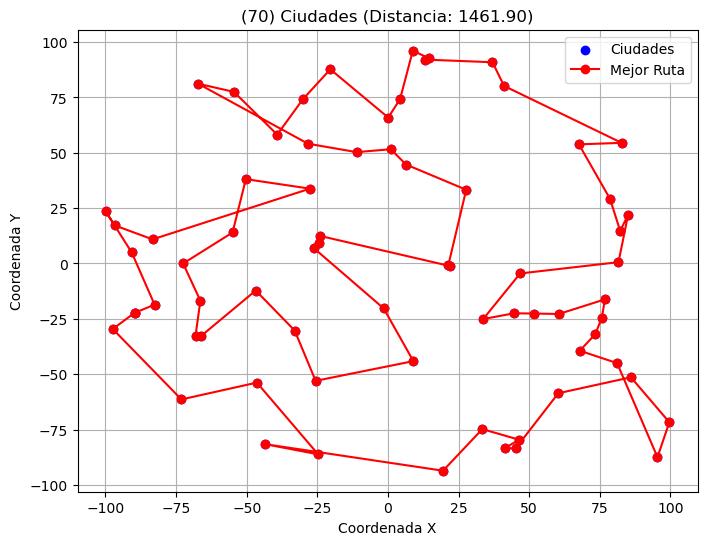

In [5]:
class TSP:
    def __init__(self, ciudades, distancias, heuristics: List[str]):
        self.max_possible_distance = None
        self.min_possible_distance = None
        self.ciudades = ciudades
        self.distancias = distancias
        self.heuristics = heuristics
        self.min_distance = get_min_distance(distancias)
        self.max_distance = get_max_distance(distancias)
        self.average_distance = get_average_distance(distancias)
        self.average_distance_for_city = get_average_distance_for_city(distancias)
        self.min_distance_for_city = get_min_distances(distancias)
        self.max_distance_for_city = get_max_distances(distancias)
        self.cal_min_max_distances()

    def cal_min_max_distances(self):
        medium_low_distance = (self.min_distance + self.average_distance) / 2
        self.min_possible_distance = medium_low_distance * len(self.ciudades) * 0.25
        self.max_possible_distance = medium_low_distance * len(self.ciudades) * 0.6


    def print_min_max_distances(self):
        print(f"Distancia mínima entre nodos: {self.min_distance}")
        print(f"Distancia máxima entre nodos: {self.max_distance}")
        print(f"Distancia promedio entre nodos: {self.average_distance}")
        print(f"Distancia Total mínima posible: {self.min_possible_distance}")
        print(f"Distancia Total máxima posible: {self.max_possible_distance}")
        print(f"Heurísticas aplicadas: {self.heuristics}")

    def encontrar_la_ruta_mas_corta(self, mipgap, time_limit, tee):
        start_time = dt.datetime.now()

        _model = pyo.ConcreteModel()

        cities = list(self.ciudades.keys())
        n_cities = len(cities)


        # Sets to work with (conjuntos)
        _model.M = pyo.Set(initialize=self.ciudades.keys())
        _model.N = pyo.Set(initialize=self.ciudades.keys())

        # Index for the dummy variable u
        _model.U = pyo.Set(initialize=cities[1:])

        # Variables
        _model.x = pyo.Var(_model.N, _model.M, within=pyo.Binary)
        _model.u = pyo.Var(_model.N, bounds=(0, n_cities - 1), within=pyo.NonNegativeIntegers)

        # Objetive Function: (función objetivo a minimizar)
        def obj_rule(model):
            return sum(self.distancias[i, j] * model.x[i, j] for i in model.N for j in model.M if i != j)

        _model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

        # Restricciones
        # Desde cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_desde(model, city_j):
            return sum(model.x[i, city_j]  for i in model.N if city_j != i) == 1

        _model.one_way_i_j = pyo.Constraint(_model.M, rule=regla_una_entrada_una_salida_por_ciudad_desde)

        # Hacia cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_hacia(model, city_i):
            return sum(model.x[city_i, j] for j in model.M if city_i != j) == 1

        _model.one_way_j_i = pyo.Constraint(_model.N, rule=regla_una_entrada_una_salida_por_ciudad_hacia)

        def rule_formando_path(model, i, j):
            if i != j:
                return model.u[i] - model.u[j] + model.x[i, j] * n_cities <= n_cities - 1
            else:
                # No se puede ir de una ciudad a la misma
                return pyo.Constraint.Skip

        _model.complete_path = pyo.Constraint(_model.U, _model.N, rule=rule_formando_path)

        def rule_asegurar_viaje(model, i, j):
            if i == j:
                return model.x[i, j] == 0
            return pyo.Constraint.Skip
        _model.no_self_travel = pyo.Constraint(_model.N, _model.M, rule=rule_asegurar_viaje)

        # Heurísticas:

        # Añadiendo limites a la función objetivo como una heurística
        if "limitar_funcion_objetivo" in self.heuristics:
            _model.obj_lower_bound = pyo.Constraint(expr=_model.obj >= self.min_possible_distance)
            _model.obj_upper_bound = pyo.Constraint(expr=_model.obj <= self.max_possible_distance)

        if "vecino_cercano" in self.heuristics:
            def rule_vecino_cercano(model, i, j):
                if i == j:
                    return pyo.Constraint.Skip
                print(i, self.min_distance, self.average_distance,  self.min_distance_for_city[i], self.max_distance_for_city[i], self.average_distance_for_city[i])
                if self.average_distance_for_city[i] > self.average_distance:
                     return pyo.Constraint.Skip
                expr = model.x[i,j] * self.distancias[i,j] <= (self.average_distance_for_city[i] + self.min_distance_for_city[i])/2
                return expr
            _model.nearest_neighbor = pyo.Constraint(_model.N, _model.M, rule=rule_vecino_cercano)

        # Initialize empty set for dynamic constraints (optional)
        # _model.subtour_constraint = pyo.ConstraintList()


        # Resolver el modelo
        solver = pyo.SolverFactory('glpk')
        solver.options['mipgap'] = mipgap
        solver.options['tmlim'] = time_limit
        results = solver.solve(_model, tee=tee)

        execution_time = dt.datetime.now() - start_time
        print(f"Tiempo de ejecución: {delta_time_mm_ss(execution_time)}")
        self.print_min_max_distances()

        # Mostrar resultados
        if results.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Ruta óptima encontrada:")
        else:
            print("No se encontró una solución óptima, la siguiente es la mejor solución encontrada:")

        edges = dict()
        valid_paths = []
        for v in _model.component_data_objects(pyo.Var):
            if v.domain == pyo.Boolean and v.value is not None and v.value > 0:
                edge = re.search(r'\[(\w\d)*,(\w\d)*]', v.name)
                city1, city2 = edge.group(1), edge.group(2)
                key = f"{city1}_{city2}"
                # Esto evita caer en ciclos cerrados
                if key not in valid_paths:
                    valid_paths += [f"{city1}_{city2}", f"{city2}_{city1}"]
                    edges[city1] = city2

        initial_city = cities[0]
        path = get_path(edges, initial_city, [])
        path.append(path[0])
        distance = calculate_path_distance(self.distancias, path)
        print("Distancia total recorrida:", distance)
        return path



    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, self.distancias, ruta, mostrar_anotaciones)

def study_nearest_neighbor(n_cities):
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    ruta = nearest_neighbor(ciudades, distancias)
    plotear_ruta(ciudades, distancias, ruta, True)

def study_case_1():
    # Probar con diferentes cantidades de ciudades
    for n_cities in [10, 20, 30, 40, 50]:
        print(f"\nProbando con {n_cities} ciudades...")
        ciudades, distancias = generar_ciudades_con_distancias(n_cities)
        heuristics = ['vecino_cercano']
        mipgap = 0.05
        time_limit = 30
        tee = False

        tsp = TSP(ciudades, distancias, heuristics)

        start_time = time.time()
        ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
        end_time = time.time()

        elapsed_time = end_time - start_time
        print(f"Tiempo de ejecución: {elapsed_time:.2f} segundos")

        tsp.plotear_resultado(ruta)

def study_case_2():
    n_cities = 70
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['limitar_funcion_objetivo']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.2
    time_limit = 40
    tee = False
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)

def study_case_3():
    n_cities = 100
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['vecino_cercano']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.05
    time_limit = 60
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)


if __name__ == "__main__":
    print("Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.")
    # as reference, see nearest neighbor heuristic
    study_nearest_neighbor(100)
    # Solve the TSP problem
    #study_case_1()
    study_case_2()
    #study_case_3()

Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.


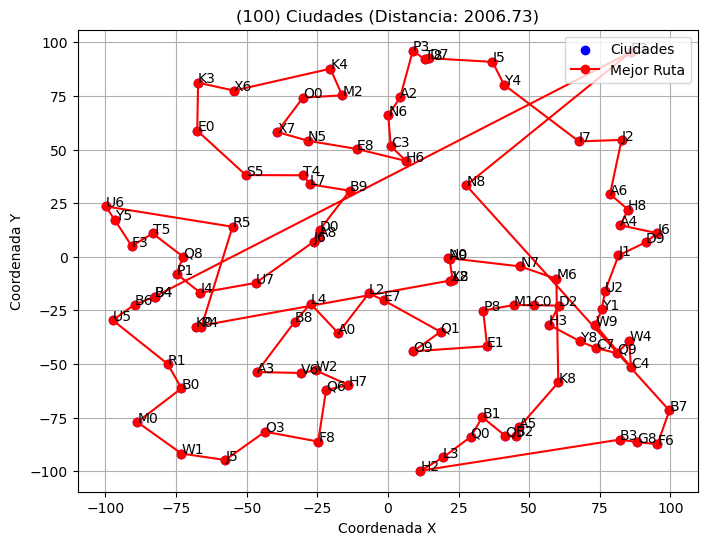

Tiempo de ejecución: 00:40
Distancia mínima entre nodos: 0.6403124237432862
Distancia máxima entre nodos: 234.3041826344549
Distancia promedio entre nodos: 100.75829712883072
Distancia Total mínima posible: 887.2378335850225
Distancia Total máxima posible: 2129.370800604054
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 1697.8332135729727


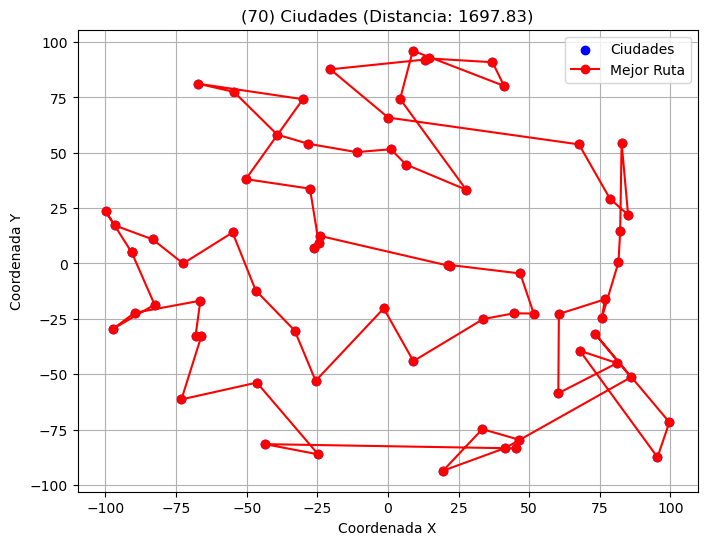

In [6]:
class TSP:
    def __init__(self, ciudades, distancias, heuristics: List[str]):
        self.max_possible_distance = None
        self.min_possible_distance = None
        self.ciudades = ciudades
        self.distancias = distancias
        self.heuristics = heuristics
        self.min_distance = get_min_distance(distancias)
        self.max_distance = get_max_distance(distancias)
        self.average_distance = get_average_distance(distancias)
        self.average_distance_for_city = get_average_distance_for_city(distancias)
        self.min_distance_for_city = get_min_distances(distancias)
        self.max_distance_for_city = get_max_distances(distancias)
        self.cal_min_max_distances()

    def cal_min_max_distances(self):
        medium_low_distance = (self.min_distance + self.average_distance) / 2
        self.min_possible_distance = medium_low_distance * len(self.ciudades) * 0.25
        self.max_possible_distance = medium_low_distance * len(self.ciudades) * 0.6


    def print_min_max_distances(self):
        print(f"Distancia mínima entre nodos: {self.min_distance}")
        print(f"Distancia máxima entre nodos: {self.max_distance}")
        print(f"Distancia promedio entre nodos: {self.average_distance}")
        print(f"Distancia Total mínima posible: {self.min_possible_distance}")
        print(f"Distancia Total máxima posible: {self.max_possible_distance}")
        print(f"Heurísticas aplicadas: {self.heuristics}")

    def encontrar_la_ruta_mas_corta(self, mipgap, time_limit, tee):
        start_time = dt.datetime.now()

        _model = pyo.ConcreteModel()

        cities = list(self.ciudades.keys())
        n_cities = len(cities)


        # Sets to work with (conjuntos)
        _model.M = pyo.Set(initialize=self.ciudades.keys())
        _model.N = pyo.Set(initialize=self.ciudades.keys())

        # Index for the dummy variable u
        _model.U = pyo.Set(initialize=cities[1:])

        # Variables
        _model.x = pyo.Var(_model.N, _model.M, within=pyo.Binary)
        _model.u = pyo.Var(_model.N, bounds=(0, n_cities - 1), within=pyo.NonNegativeIntegers)

        # Objetive Function: (función objetivo a minimizar)
        def obj_rule(model):
            return sum(self.distancias[i, j] * model.x[i, j] for i in model.N for j in model.M if i != j)

        _model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

        # Restricciones
        # Desde cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_desde(model, city_j):
            return sum(model.x[i, city_j]  for i in model.N if city_j != i) == 1

        _model.one_way_i_j = pyo.Constraint(_model.M, rule=regla_una_entrada_una_salida_por_ciudad_desde)

        # Hacia cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_hacia(model, city_i):
            return sum(model.x[city_i, j] for j in model.M if city_i != j) == 1

        _model.one_way_j_i = pyo.Constraint(_model.N, rule=regla_una_entrada_una_salida_por_ciudad_hacia)

        def rule_formando_path(model, i, j):
            if i != j:
                return model.u[i] - model.u[j] + model.x[i, j] * n_cities <= n_cities - 1
            else:
                # No se puede ir de una ciudad a la misma
                return pyo.Constraint.Skip

        _model.complete_path = pyo.Constraint(_model.U, _model.N, rule=rule_formando_path)

        def rule_asegurar_viaje(model, i, j):
            if i == j:
                return model.x[i, j] == 0
            return pyo.Constraint.Skip
        _model.no_self_travel = pyo.Constraint(_model.N, _model.M, rule=rule_asegurar_viaje)

        # Heurísticas:

        # Añadiendo limites a la función objetivo como una heurística
        if "limitar_funcion_objetivo" in self.heuristics:
            _model.obj_lower_bound = pyo.Constraint(expr=_model.obj >= self.min_possible_distance)
            _model.obj_upper_bound = pyo.Constraint(expr=_model.obj <= self.max_possible_distance)

        if "vecino_cercano" in self.heuristics:
            def rule_vecino_cercano(model, i, j):
                if i == j:
                    return pyo.Constraint.Skip
                print(i, self.min_distance, self.average_distance,  self.min_distance_for_city[i], self.max_distance_for_city[i], self.average_distance_for_city[i])
                if self.average_distance_for_city[i] > self.average_distance:
                     return pyo.Constraint.Skip
                expr = model.x[i,j] * self.distancias[i,j] <= (self.average_distance_for_city[i] + self.min_distance_for_city[i])/2
                return expr
            _model.nearest_neighbor = pyo.Constraint(_model.N, _model.M, rule=rule_vecino_cercano)

        # Initialize empty set for dynamic constraints (optional)
        # _model.subtour_constraint = pyo.ConstraintList()


        # Resolver el modelo
        solver = pyo.SolverFactory('glpk')
        solver.options['mipgap'] = mipgap
        solver.options['tmlim'] = time_limit
        results = solver.solve(_model, tee=tee)

        execution_time = dt.datetime.now() - start_time
        print(f"Tiempo de ejecución: {delta_time_mm_ss(execution_time)}")
        self.print_min_max_distances()

        # Mostrar resultados
        if results.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Ruta óptima encontrada:")
        else:
            print("No se encontró una solución óptima, la siguiente es la mejor solución encontrada:")

        edges = dict()
        valid_paths = []
        for v in _model.component_data_objects(pyo.Var):
            if v.domain == pyo.Boolean and v.value is not None and v.value > 0:
                edge = re.search(r'\[(\w\d)*,(\w\d)*]', v.name)
                city1, city2 = edge.group(1), edge.group(2)
                key = f"{city1}_{city2}"
                # Esto evita caer en ciclos cerrados
                if key not in valid_paths:
                    valid_paths += [f"{city1}_{city2}", f"{city2}_{city1}"]
                    edges[city1] = city2

        initial_city = cities[0]
        path = get_path(edges, initial_city, [])
        path.append(path[0])
        distance = calculate_path_distance(self.distancias, path)
        print("Distancia total recorrida:", distance)
        return path



    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, self.distancias, ruta, mostrar_anotaciones)

def study_nearest_neighbor(n_cities):
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    ruta = nearest_neighbor(ciudades, distancias)
    plotear_ruta(ciudades, distancias, ruta, True)

def study_case_1():
    # Probar con diferentes cantidades de ciudades
    for n_cities in [10, 20, 30, 40, 50]:
        print(f"\nProbando con {n_cities} ciudades...")
        ciudades, distancias = generar_ciudades_con_distancias(n_cities)
        heuristics = ['vecino_cercano']
        mipgap = 0.05
        time_limit = 30
        tee = False

        tsp = TSP(ciudades, distancias, heuristics)

        start_time = time.time()
        ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
        end_time = time.time()

        elapsed_time = end_time - start_time
        print(f"Tiempo de ejecución: {elapsed_time:.2f} segundos")

        tsp.plotear_resultado(ruta)

def study_case_2():
    n_cities = 70
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    #heuristics = ['limitar_funcion_objetivo']
    # sin heuristicas
    heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.2
    time_limit = 40
    tee = False
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)

def study_case_3():
    n_cities = 100
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['vecino_cercano']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.05
    time_limit = 60
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)


if __name__ == "__main__":
    print("Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.")
    # as reference, see nearest neighbor heuristic
    study_nearest_neighbor(100)
    # Solve the TSP problem
    #study_case_1()
    study_case_2()
    #study_case_3()

 ¿Cuál es la diferencia entre los dos casos? 
 
 La aplicación de la heurística permitió encontrar una mejor solución (más corta) en el mismo tiempo de ejecución.

¿Sirve esta heurística para cualquier caso? ¿Cuál pudiera ser una razón?

La heurística limitar_funcion_objetivo puede ser útil en algunos casos, pero no garantiza mejoras en todos los contextos. Esto se debe a que:

1. Las heurísticas suelen estar diseñadas para reducir el espacio de búsqueda, enfocándose en soluciones más prometedoras, pero:

2. Pueden omitir soluciones óptimas si las restricciones impuestas son demasiado fuertes.

En este caso, funcionó bien porque probablemente acotó las soluciones malas, permitiendo al algoritmo concentrarse en rutas más eficientes.

## Aplicar	heurística	de	vecinos	cercanos (caso 3)	

Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.


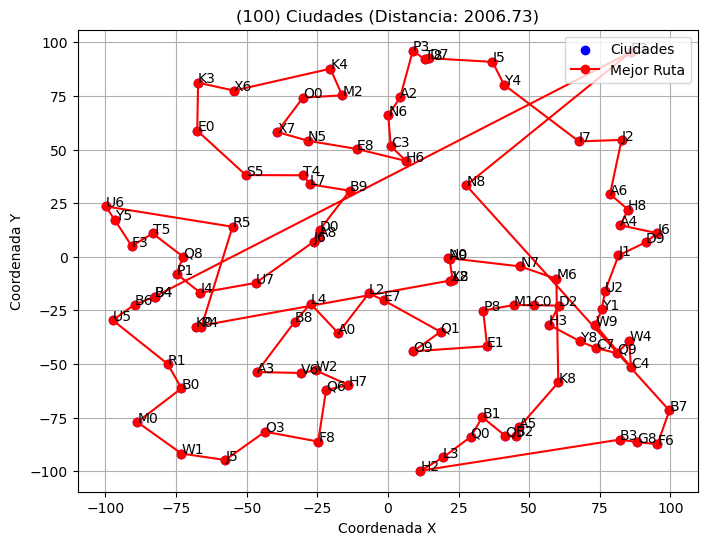

B4 0.6403124237432862 100.94053659793771 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793771 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793771 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793771 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793771 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793771 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793771 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793771 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793771 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.94053659793771 8.006247560499245 203.44102339498787 106.77422691409892
B4 0.6403124237432862 100.9405

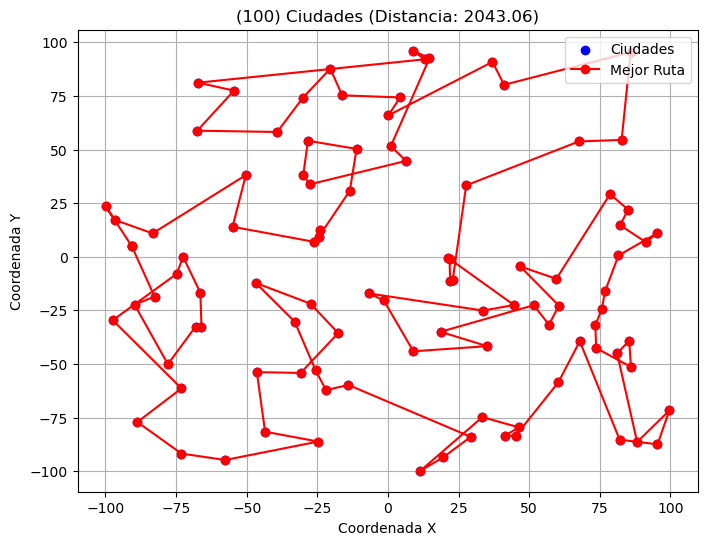

In [8]:
class TSP:
    def __init__(self, ciudades, distancias, heuristics: List[str]):
        self.max_possible_distance = None
        self.min_possible_distance = None
        self.ciudades = ciudades
        self.distancias = distancias
        self.heuristics = heuristics
        self.min_distance = get_min_distance(distancias)
        self.max_distance = get_max_distance(distancias)
        self.average_distance = get_average_distance(distancias)
        self.average_distance_for_city = get_average_distance_for_city(distancias)
        self.min_distance_for_city = get_min_distances(distancias)
        self.max_distance_for_city = get_max_distances(distancias)
        self.cal_min_max_distances()

    def cal_min_max_distances(self):
        medium_low_distance = (self.min_distance + self.average_distance) / 2
        self.min_possible_distance = medium_low_distance * len(self.ciudades) * 0.25
        self.max_possible_distance = medium_low_distance * len(self.ciudades) * 0.6


    def print_min_max_distances(self):
        print(f"Distancia mínima entre nodos: {self.min_distance}")
        print(f"Distancia máxima entre nodos: {self.max_distance}")
        print(f"Distancia promedio entre nodos: {self.average_distance}")
        print(f"Distancia Total mínima posible: {self.min_possible_distance}")
        print(f"Distancia Total máxima posible: {self.max_possible_distance}")
        print(f"Heurísticas aplicadas: {self.heuristics}")

    def encontrar_la_ruta_mas_corta(self, mipgap, time_limit, tee):
        start_time = dt.datetime.now()

        _model = pyo.ConcreteModel()

        cities = list(self.ciudades.keys())
        n_cities = len(cities)


        # Sets to work with (conjuntos)
        _model.M = pyo.Set(initialize=self.ciudades.keys())
        _model.N = pyo.Set(initialize=self.ciudades.keys())

        # Index for the dummy variable u
        _model.U = pyo.Set(initialize=cities[1:])

        # Variables
        _model.x = pyo.Var(_model.N, _model.M, within=pyo.Binary)
        _model.u = pyo.Var(_model.N, bounds=(0, n_cities - 1), within=pyo.NonNegativeIntegers)

        # Objetive Function: (función objetivo a minimizar)
        def obj_rule(model):
            return sum(self.distancias[i, j] * model.x[i, j] for i in model.N for j in model.M if i != j)

        _model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

        # Restricciones
        # Desde cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_desde(model, city_j):
            return sum(model.x[i, city_j]  for i in model.N if city_j != i) == 1

        _model.one_way_i_j = pyo.Constraint(_model.M, rule=regla_una_entrada_una_salida_por_ciudad_desde)

        # Hacia cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_hacia(model, city_i):
            return sum(model.x[city_i, j] for j in model.M if city_i != j) == 1

        _model.one_way_j_i = pyo.Constraint(_model.N, rule=regla_una_entrada_una_salida_por_ciudad_hacia)

        def rule_formando_path(model, i, j):
            if i != j:
                return model.u[i] - model.u[j] + model.x[i, j] * n_cities <= n_cities - 1
            else:
                # No se puede ir de una ciudad a la misma
                return pyo.Constraint.Skip

        _model.complete_path = pyo.Constraint(_model.U, _model.N, rule=rule_formando_path)

        def rule_asegurar_viaje(model, i, j):
            if i == j:
                return model.x[i, j] == 0
            return pyo.Constraint.Skip
        _model.no_self_travel = pyo.Constraint(_model.N, _model.M, rule=rule_asegurar_viaje)

        # Heurísticas:

        # Añadiendo limites a la función objetivo como una heurística
        if "limitar_funcion_objetivo" in self.heuristics:
            _model.obj_lower_bound = pyo.Constraint(expr=_model.obj >= self.min_possible_distance)
            _model.obj_upper_bound = pyo.Constraint(expr=_model.obj <= self.max_possible_distance)

        if "vecino_cercano" in self.heuristics:
            def rule_vecino_cercano(model, i, j):
                if i == j:
                    return pyo.Constraint.Skip
                print(i, self.min_distance, self.average_distance,  self.min_distance_for_city[i], self.max_distance_for_city[i], self.average_distance_for_city[i])
                if self.average_distance_for_city[i] > self.average_distance:
                     return pyo.Constraint.Skip
                expr = model.x[i,j] * self.distancias[i,j] <= (self.average_distance_for_city[i] + self.min_distance_for_city[i])/2
                return expr
            _model.nearest_neighbor = pyo.Constraint(_model.N, _model.M, rule=rule_vecino_cercano)

        # Initialize empty set for dynamic constraints (optional)
        # _model.subtour_constraint = pyo.ConstraintList()


        # Resolver el modelo
        solver = pyo.SolverFactory('glpk')
        solver.options['mipgap'] = mipgap
        solver.options['tmlim'] = time_limit
        results = solver.solve(_model, tee=tee)

        execution_time = dt.datetime.now() - start_time
        print(f"Tiempo de ejecución: {delta_time_mm_ss(execution_time)}")
        self.print_min_max_distances()

        # Mostrar resultados
        if results.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Ruta óptima encontrada:")
        else:
            print("No se encontró una solución óptima, la siguiente es la mejor solución encontrada:")

        edges = dict()
        valid_paths = []
        for v in _model.component_data_objects(pyo.Var):
            if v.domain == pyo.Boolean and v.value is not None and v.value > 0:
                edge = re.search(r'\[(\w\d)*,(\w\d)*]', v.name)
                city1, city2 = edge.group(1), edge.group(2)
                key = f"{city1}_{city2}"
                # Esto evita caer en ciclos cerrados
                if key not in valid_paths:
                    valid_paths += [f"{city1}_{city2}", f"{city2}_{city1}"]
                    edges[city1] = city2

        initial_city = cities[0]
        path = get_path(edges, initial_city, [])
        path.append(path[0])
        distance = calculate_path_distance(self.distancias, path)
        print("Distancia total recorrida:", distance)
        return path



    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, self.distancias, ruta, mostrar_anotaciones)

def study_nearest_neighbor(n_cities):
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    ruta = nearest_neighbor(ciudades, distancias)
    plotear_ruta(ciudades, distancias, ruta, True)

def study_case_1():
    # Probar con diferentes cantidades de ciudades
    for n_cities in [10, 20, 30, 40, 50]:
        print(f"\nProbando con {n_cities} ciudades...")
        ciudades, distancias = generar_ciudades_con_distancias(n_cities)
        heuristics = ['vecino_cercano']
        mipgap = 0.05
        time_limit = 30
        tee = False

        tsp = TSP(ciudades, distancias, heuristics)

        start_time = time.time()
        ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
        end_time = time.time()

        elapsed_time = end_time - start_time
        print(f"Tiempo de ejecución: {elapsed_time:.2f} segundos")

        tsp.plotear_resultado(ruta)

def study_case_2():
    n_cities = 70
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    #heuristics = ['limitar_funcion_objetivo']
    # sin heuristicas
    heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.2
    time_limit = 40
    tee = False
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)

def study_case_3():
    n_cities = 100
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['vecino_cercano']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.05
    time_limit = 60
    tee = False
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)


if __name__ == "__main__":
    print("Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.")
    # as reference, see nearest neighbor heuristic
    study_nearest_neighbor(100)
    # Solve the TSP problem
    #study_case_1()
    #study_case_2()
    study_case_3()

Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.


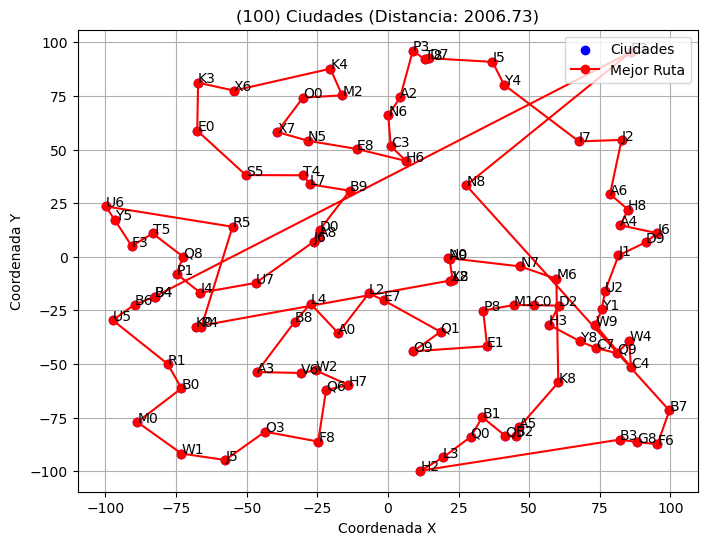

Tiempo de ejecución: 01:02
Distancia mínima entre nodos: 0.6403124237432862
Distancia máxima entre nodos: 245.61115609841502
Distancia promedio entre nodos: 100.94053659793771
Distancia Total mínima posible: 1269.7606127710123
Distancia Total máxima posible: 3047.4254706504294
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 0
La ruta contiene valores nulos, no se encontró una solución válida.


In [9]:
class TSP:
    def __init__(self, ciudades, distancias, heuristics: List[str]):
        self.max_possible_distance = None
        self.min_possible_distance = None
        self.ciudades = ciudades
        self.distancias = distancias
        self.heuristics = heuristics
        self.min_distance = get_min_distance(distancias)
        self.max_distance = get_max_distance(distancias)
        self.average_distance = get_average_distance(distancias)
        self.average_distance_for_city = get_average_distance_for_city(distancias)
        self.min_distance_for_city = get_min_distances(distancias)
        self.max_distance_for_city = get_max_distances(distancias)
        self.cal_min_max_distances()

    def cal_min_max_distances(self):
        medium_low_distance = (self.min_distance + self.average_distance) / 2
        self.min_possible_distance = medium_low_distance * len(self.ciudades) * 0.25
        self.max_possible_distance = medium_low_distance * len(self.ciudades) * 0.6


    def print_min_max_distances(self):
        print(f"Distancia mínima entre nodos: {self.min_distance}")
        print(f"Distancia máxima entre nodos: {self.max_distance}")
        print(f"Distancia promedio entre nodos: {self.average_distance}")
        print(f"Distancia Total mínima posible: {self.min_possible_distance}")
        print(f"Distancia Total máxima posible: {self.max_possible_distance}")
        print(f"Heurísticas aplicadas: {self.heuristics}")

    def encontrar_la_ruta_mas_corta(self, mipgap, time_limit, tee):
        start_time = dt.datetime.now()

        _model = pyo.ConcreteModel()

        cities = list(self.ciudades.keys())
        n_cities = len(cities)


        # Sets to work with (conjuntos)
        _model.M = pyo.Set(initialize=self.ciudades.keys())
        _model.N = pyo.Set(initialize=self.ciudades.keys())

        # Index for the dummy variable u
        _model.U = pyo.Set(initialize=cities[1:])

        # Variables
        _model.x = pyo.Var(_model.N, _model.M, within=pyo.Binary)
        _model.u = pyo.Var(_model.N, bounds=(0, n_cities - 1), within=pyo.NonNegativeIntegers)

        # Objetive Function: (función objetivo a minimizar)
        def obj_rule(model):
            return sum(self.distancias[i, j] * model.x[i, j] for i in model.N for j in model.M if i != j)

        _model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

        # Restricciones
        # Desde cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_desde(model, city_j):
            return sum(model.x[i, city_j]  for i in model.N if city_j != i) == 1

        _model.one_way_i_j = pyo.Constraint(_model.M, rule=regla_una_entrada_una_salida_por_ciudad_desde)

        # Hacia cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_hacia(model, city_i):
            return sum(model.x[city_i, j] for j in model.M if city_i != j) == 1

        _model.one_way_j_i = pyo.Constraint(_model.N, rule=regla_una_entrada_una_salida_por_ciudad_hacia)

        def rule_formando_path(model, i, j):
            if i != j:
                return model.u[i] - model.u[j] + model.x[i, j] * n_cities <= n_cities - 1
            else:
                # No se puede ir de una ciudad a la misma
                return pyo.Constraint.Skip

        _model.complete_path = pyo.Constraint(_model.U, _model.N, rule=rule_formando_path)

        def rule_asegurar_viaje(model, i, j):
            if i == j:
                return model.x[i, j] == 0
            return pyo.Constraint.Skip
        _model.no_self_travel = pyo.Constraint(_model.N, _model.M, rule=rule_asegurar_viaje)

        # Heurísticas:

        # Añadiendo limites a la función objetivo como una heurística
        if "limitar_funcion_objetivo" in self.heuristics:
            _model.obj_lower_bound = pyo.Constraint(expr=_model.obj >= self.min_possible_distance)
            _model.obj_upper_bound = pyo.Constraint(expr=_model.obj <= self.max_possible_distance)

        if "vecino_cercano" in self.heuristics:
            def rule_vecino_cercano(model, i, j):
                if i == j:
                    return pyo.Constraint.Skip
                print(i, self.min_distance, self.average_distance,  self.min_distance_for_city[i], self.max_distance_for_city[i], self.average_distance_for_city[i])
                if self.average_distance_for_city[i] > self.average_distance:
                     return pyo.Constraint.Skip
                expr = model.x[i,j] * self.distancias[i,j] <= (self.average_distance_for_city[i] + self.min_distance_for_city[i])/2
                return expr
            _model.nearest_neighbor = pyo.Constraint(_model.N, _model.M, rule=rule_vecino_cercano)

        # Initialize empty set for dynamic constraints (optional)
        # _model.subtour_constraint = pyo.ConstraintList()


        # Resolver el modelo
        solver = pyo.SolverFactory('glpk')
        solver.options['mipgap'] = mipgap
        solver.options['tmlim'] = time_limit
        results = solver.solve(_model, tee=tee)

        execution_time = dt.datetime.now() - start_time
        print(f"Tiempo de ejecución: {delta_time_mm_ss(execution_time)}")
        self.print_min_max_distances()

        # Mostrar resultados
        if results.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Ruta óptima encontrada:")
        else:
            print("No se encontró una solución óptima, la siguiente es la mejor solución encontrada:")

        edges = dict()
        valid_paths = []
        for v in _model.component_data_objects(pyo.Var):
            if v.domain == pyo.Boolean and v.value is not None and v.value > 0:
                edge = re.search(r'\[(\w\d)*,(\w\d)*]', v.name)
                city1, city2 = edge.group(1), edge.group(2)
                key = f"{city1}_{city2}"
                # Esto evita caer en ciclos cerrados
                if key not in valid_paths:
                    valid_paths += [f"{city1}_{city2}", f"{city2}_{city1}"]
                    edges[city1] = city2

        initial_city = cities[0]
        path = get_path(edges, initial_city, [])
        path.append(path[0])
        distance = calculate_path_distance(self.distancias, path)
        print("Distancia total recorrida:", distance)
        return path



    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, self.distancias, ruta, mostrar_anotaciones)

def study_nearest_neighbor(n_cities):
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    ruta = nearest_neighbor(ciudades, distancias)
    plotear_ruta(ciudades, distancias, ruta, True)

def study_case_1():
    # Probar con diferentes cantidades de ciudades
    for n_cities in [10, 20, 30, 40, 50]:
        print(f"\nProbando con {n_cities} ciudades...")
        ciudades, distancias = generar_ciudades_con_distancias(n_cities)
        heuristics = ['vecino_cercano']
        mipgap = 0.05
        time_limit = 30
        tee = False

        tsp = TSP(ciudades, distancias, heuristics)

        start_time = time.time()
        ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
        end_time = time.time()

        elapsed_time = end_time - start_time
        print(f"Tiempo de ejecución: {elapsed_time:.2f} segundos")

        tsp.plotear_resultado(ruta)

def study_case_2():
    n_cities = 70
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    #heuristics = ['limitar_funcion_objetivo']
    # sin heuristicas
    heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.2
    time_limit = 40
    tee = False
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)

def study_case_3():
    n_cities = 100
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    #heuristics = ['vecino_cercano']
    # sin heuristicas
    heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.05
    time_limit = 60
    tee = False
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)


if __name__ == "__main__":
    print("Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.")
    # as reference, see nearest neighbor heuristic
    study_nearest_neighbor(100)
    # Solve the TSP problem
    #study_case_1()
    #study_case_2()
    study_case_3()

¿Cuál es la diferencia entre los dos casos? 

Si bien es cierto que tanto los tiempos de ejecución y los valores estadísticos son los mismos, la diferencia principal es que cuando se aplicó la heurística del vecino_cercano se pudo llegar a una ruta con distancia total (no óptima). 

¿Sirve esta heurística para cualquier caso? 

La heurística vecino_cercano no garantiza la mejor solución, pero sí ayuda a obtener una solución válida en muchos casos.

Conclusiones:

El TSP es un problema NP-duro, lo que significa que el tiempo de resolución crece exponencialmente con el número de ciudades.

Para pocas ciudades (10 o 20), se puede analizar la mayoría del espacio de soluciones sin heurísticas.

A partir de 30 ciudades, la cantidad de rutas posibles se vuelve muy dificil de cuantificar, por lo que los métodos exactos sin heurísticas fallan.

Las heurísticas permiten encontrar soluciones viables en tiempos razonables

Usar heuristicas aumentan la capacidad para resolver instancias con muchas ciudades

Aunque no óptimas, las soluciones suelen ser suficientemente buenas para la mayoría de aplicaciones prácticas.

Hay diferentes tipos de heuristicas por lo que la calidad depende del tipo de heurística usada